Load the 30 Value Weighted industry portfolio returns. Limit the analysis to returns of the 30 VW portfolios from 1997 onwards (1997 included, 1996 not included, 2018 included). Also load the Market Caps of each of the 30 industries. Run a backtest of comparing a CapWeighted vs an EW portfolio over the period. Though these two weighting schemes do not need any estimation, use an estimation period of 36 months so that we can compare it in the next few questions. 

In [1]:
import numpy as np
import pandas as pd

import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=30)["1997":"2018"]
ind_mcap = erk.get_ind_market_caps(30, weights=True)["1997":"2018"]

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
eW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.53298
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.51899


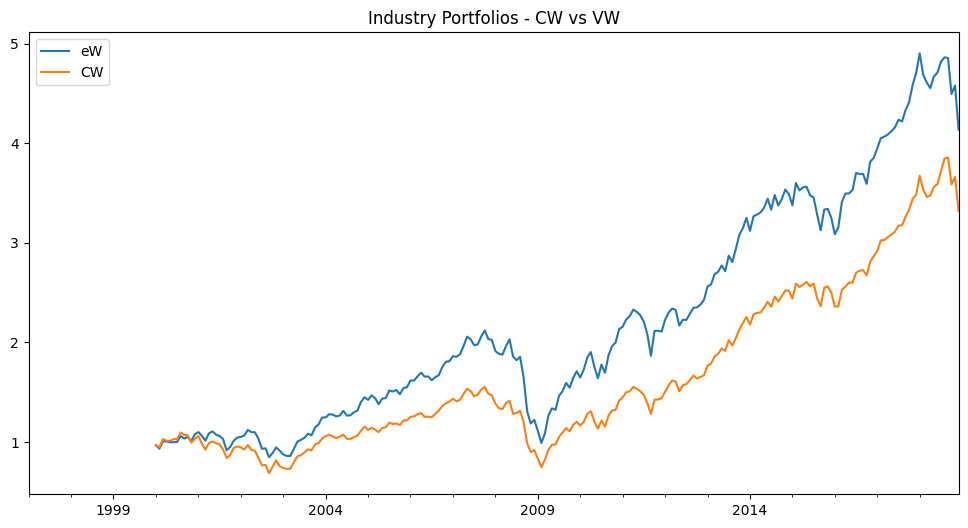

In [2]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36)
cwr = erk.backtest_ws(ind_rets, estimation_window=36,weighting=erk.weight_cw,  cap_weights=ind_mcap)
btr = pd.DataFrame({"eW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs VW")
erk.summary_stats(btr.dropna())

------

Now using the same data and same period, re-run the EW backtest but this time create a tethered EW portfolio by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X What was the annualized return over the period for the tethered Equal Weighted Industry Portfolio?

In [8]:
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=30)["1997":"2018"]
ind_mcap = erk.get_ind_market_caps(30, weights=True)["1997":"2018"]
ewtr = erk.backtest_ws(ind_rets, cap_weights=ind_mcap, max_cw_mult=2, microcap_threshold=.01, estimation_window=36 )

In [9]:
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "EWRT": ewtr})

In [10]:
erk.summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
EWRT,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413


What was Tracking Error between the Pure EW (without any tethering) portfolio and the CW portfolio?

Tracking error: The difference in actual performance between a position (usually an entire portfolio) and its corresponding benchmark.

The tracking error can be viewed as an indicator of how actively a fund is managed and its corresponding risk level.

In [11]:
erk.tracking_error(ewr, cwr)

0.18752094143646486

Now consider the Tethered EW portfolio you previously created (by removing Microcap industries using a threshold of 1% and a max cap-weight multiple of 2X)

In [12]:
erk.tracking_error(ewtr, cwr)

0.11671015519949166

Run a backtest for the same period (1997 onwards i.e. 1997 included, 1996 not included, 2018 included), using an estimation window of 36 months as above, to build the Global Minimum Variance Portfolio by estimating the Covariance matrix using Sample Covariance. What was the annualized return over the period for the GMV Portfolio?

In [13]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

In [14]:
def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
GMV-Sample,0.066306,0.117410,-0.741079,4.469199,0.055456,0.080583,0.300819,-0.421289


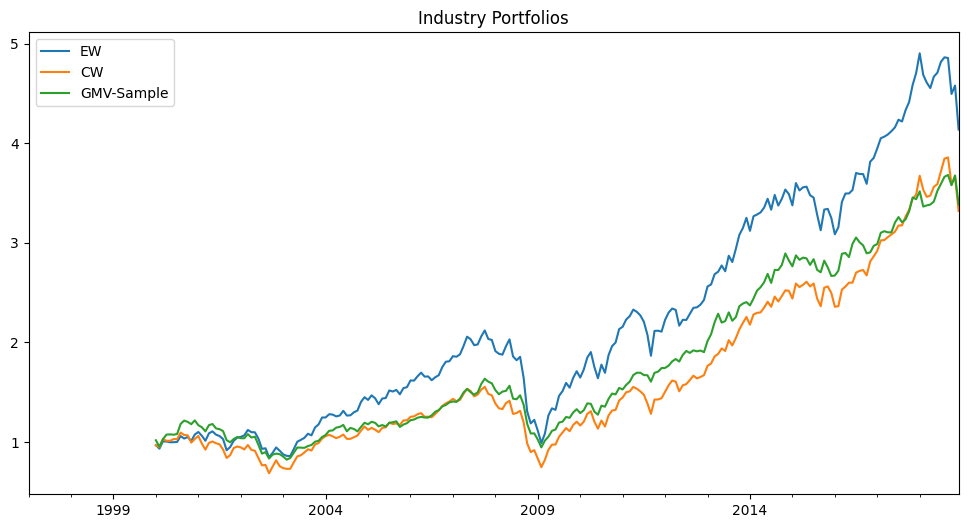

In [15]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Run a backtest for the same period as the previous question, and again using an estimation window of 36 months as above, to build the Global Minimum Variance Portfolio but this time, estimating the Covariance matrix using Shrinkage between the Constant Correlation and Sample Covariance estimates using a delta of 0.25. 

In [16]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

In [17]:
#import statsmodels.stats.moment_helpers as mh
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
#     mh.corr2cov(ccor, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.065196,0.151478,-0.556621,4.249894,0.071076,0.098531,0.225949,-0.518990
GMV-Sample,0.066306,0.117410,-0.741079,4.469199,0.055456,0.080583,0.300819,-0.421289
GMV-CC,0.074342,0.111389,-0.723769,4.153322,0.051799,0.074172,0.387316,-0.340641
GMV-Shrink 0.25,0.068466,0.114572,-0.731282,4.264914,0.053884,0.077715,0.326628,-0.393410


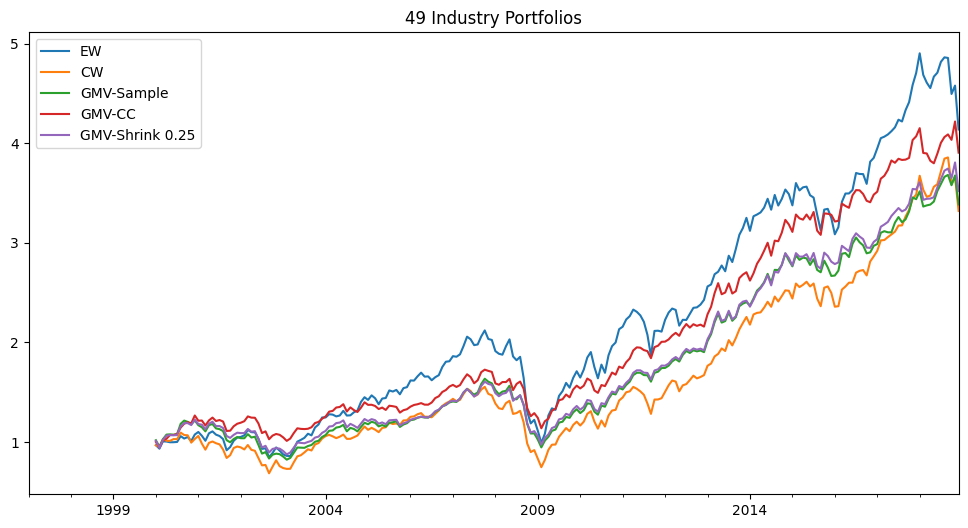

In [18]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=cc_cov)
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.25)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.25': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna())